In [35]:
import pickle
import numpy as np
import os

CIFAR_DIR = "..\\cifar-10-batches-py"

print(os.listdir(CIFAR_DIR))

['batches.meta', 'data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5', 'readme.html', 'test_batch']


In [36]:
with open(os.path.join(CIFAR_DIR, "data_batch_1"), 'rb') as f:
    data = pickle.load(f, encoding='bytes')
    print(type(data))
    print(data.keys())
    print(type(data[b'batch_label']))
    print(type(data[b'labels']))
    print(type(data[b'data']))
    print(type(data[b'filenames']))

    print(data[b'data'].shape)
    print(data[b'data'][0:2])
    print(data[b'labels'][0:2])
    print(data[b'batch_label'])
    print(data[b'filenames'][0:2])

# 32 * 32 = 1024 1024 * 3 = 3072
# RR-GG-BB = 3072

<class 'dict'>
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
<class 'bytes'>
<class 'list'>
<class 'numpy.ndarray'>
<class 'list'>
(10000, 3072)
[[ 59  43  50 ... 140  84  72]
 [154 126 105 ... 139 142 144]]
[6, 9]
b'training batch 1 of 5'
[b'leptodactylus_pentadactylus_s_000004.png', b'camion_s_000148.png']


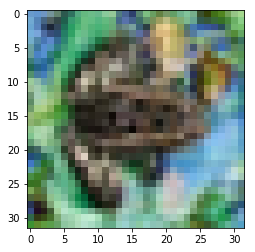

In [37]:
image_arr = data[b'data'][200]
image_arr = image_arr.reshape((3, 32, 32))
image_arr = image_arr.transpose((1, 2, 0))  #32 32 3

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

imshow(image_arr)

In [60]:
import tensorflow as tf

def load_data(filename):
    """read data from data file"""
    with open(filename, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
        return data[b'data'],data[b'labels']

class CifarData:
    def __init__(self, filenames, need_shuffle):
        all_data = []
        all_labels = []
        for filename in filenames:
            data, labels = load_data(filename)
            for item, label in zip(data, labels):
                if label in [0, 1]:
                    all_data.append(item)
                    all_labels.append(label)
        self._data = np.vstack(all_data)
        self._labels = np.hstack(all_labels)
        print(self._data.shape)
        print(self._labels.shape)
        self._num_examples = self._data.shape[0]
        self._need_shuffle = need_shuffle
        self._indicator = 0
        if self._need_shuffle:
            self._shuffle_data()
        
    def _shuffle_data(self):
        p = np.random.permutation(self._num_examples)
        self._data = self._data[p]
        self._labels = self._labels[p]

    def next_batch(self, batch_size):
        """return batch_size examples as a batch"""
        end_indicator = self._indicator + batch_size
        if end_indicator > self._num_examples:
            if self._need_shuffle:          
                self._shuffle_data()
                self._indicator = 0
                end_indicator = batch_size
            else:
                raise Exception("have no more examples")
        if end_indicator > self._num_examples:
            raise Exception("batch size is lager than all example")
        batch_data = self._data[self._indicator: end_indicator]
        batch_labels = self._labels[self._indicator: end_indicator]
        self._indicator = end_indicator
        return batch_data, batch_labels

train_filenames = [os.path.join(CIFAR_DIR, "data_batch_%d" % i) for i in range(1, 6)]
test_filenames = [os.path.join(CIFAR_DIR, "test_batch")]


test_data = CifarData(test_filenames, True)

(10000, 3072)
(10000,)
(2000, 3072)
(2000,)


In [40]:
x = tf.placeholder(tf.float32, [None, 3072])    # None 输入个数不确定
# [None]
y = tf.placeholder(tf.int64, [None])

# (3072, 1)
w = tf.get_variable('w', [x.get_shape()[-1], 1], initializer=tf.random_normal_initializer(0, 1))

# (1, )
b = tf.get_variable('b', [1], initializer=tf.constant_initializer(0.0))

# [None, 3072] * [3072, 1] = [None, 1]
y_ = tf.matmul(x, w) + b
# [None, 1]
p_y_1 = tf.nn.sigmoid(y_)  # 得到概率值

# [None, 1]
y_reshaped = tf.reshape(y, (-1, 1))
y_reshaped_float = tf.cast(y_reshaped, tf.float32)

loss = tf.reduce_mean(tf.square(y_reshaped_float - p_y_1))

# bool
predict = p_y_1 > 0.5
correct_prediction = tf.equal(tf.cast(predict, tf.int64), y_reshaped)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float64))

with tf.name_scope('train_op'):
    train_op = tf.train.AdamOptimizer(1e-3).minimize(loss)  # 最小化loss

In [ ]:
init = tf.global_variables_initializer()
batch_size = 20
train_steps = 1000
test_steps = 100

with tf.Session() as sess:
    for i in range(train_steps):
        batch_data, batch_labels = train_data.next_batch(batch_size)
        loss_val, acc_val, _ = sess.run([loss, accuracy, train_op], feed_dict={x: batch_data, y: batch_labels})
        if i % 500 == 0:
            print('[Train] Step：%d, loss: %4.5f, acc: %4.5f' % (i + 1, loss_val, acc_val))
        if i % 5000 == 0:
            test_data = CifarData(test_filenames, False)
            all_test_acc_val = []
            for j in range(test_steps):
                test_batch_data, test_batch_labels = test_data.next_batch(batch_size)
                test_acc_val = sess.run([accuracy, feed_dict={x:test_batch_data,y:test_batch_labels}])
            test_acc = np.mean(all_test_acc_val)
            print('[Test] Step: %d, acc: %4.5f' % (i+1, test_acc_val))





















